**Problema de negócio:**
A empresa CCD é uma empresa que oferece o SERVIÇO de DIAGNÓSTICO DE DOENÇAS CARDIOVASCULATES EM ESTÁGIOS INICIAIS.
O custo de cada diagnóstico é de R$ 1000,00. 
O preço que o cliente paga por cada diagnóstico paga é de 500 reais a cada 5% de acurácia acima de 50%.
Hoje, a precisão dos diagnósticos varia de 55 a 65%, o que faz com que a empresa hora tenha um lucro de 500 reais, hora tenha um prejuízo, hora se pague.
O problema é a IMPREVISIBILIDADE DO FLUXO DE CAIXA. Portanto, precisamos criar um modelo que tenha a mesma acurácia em todas as previsões, respondendo as seguitnes perguntas: 

    1. Qual a Acurácia e a Precisão da ferramenta?
    2. Quanto lucro a Cardio Catch Diseases passará a ter com a nova ferramenta?
    3. Qual a Confiabilidade do resultado dados pela nova ferramenta?


Planejamento da solução: 

1. Encontrar um dataset com features e ocorrência de cardio catch disease
2. Limpar, explorar e fazer as features engineerings necessárias -> pesquisar sobre suas influências nas doenças de coração
3. Criar hipóteses e retirar insights
4. Selecionar as features mais relevantes
5. Aplicar modelos de machine learning
6. Fazer as avaliações dos modelos e escolher o que irá para produção


# Imports

In [81]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestRegressor
from boruta                  import BorutaPy


## Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

#feature engineering functions
    
def hypertension(high, low):
    if high >= 140 and (low >= 90):
        hypertense = 1
        
    else: 
         
        hypertense = 0
    return hypertense


def obesity(height, weight):
    imc = weight/((height/100) ** 2)
    
    if imc >= 25:
        if imc >= 30:
            if imc >= 40:
                obesity = 3
            else:
                obesity = 2
        else:
            obesity = 1
    else: 
        obesity = 0
    
    return obesity



def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])

    # compute IQR
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]

    return outliers

def bounds(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])

    # compute IQR
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    return lower_bound, upper_bound
        
    

def stacked_barplot(data, feature):
    

    # raw value to percentage
    total = data.groupby(feature)['id'].count().reset_index()
    sick = data[data['cardio'] == 1].groupby(feature)['id'].count().reset_index()
    sick['id'] = [ i / j * 100 for i,j in zip(sick['id'], total['id'])]
    total['id'] = [i / j * 100 for i,j in zip(total['id'], total['id'] ) ]

    # bar chart 1  = top bars( group of healthy)
    bar1 = sns.barplot(x=feature, y='id', data = total, color='darkblue')

    # bar chart 2 = bottom bars (group of sick)
    bar2 = sns.barplot(x=feature, y='id', data =  sick, color = 'lightblue')

    # legend
    top_bar = mpatches.Patch(color='darkblue', label='CVD = No')
    bottom_bar = mpatches.Patch(color='lightblue', label='CVD = Yes')
    plt.legend(handles=[top_bar, bottom_bar])

    # show the graph
    graph = plt.show()
    
    return graph

Populating the interactive namespace from numpy and matplotlib


# Data collection

In [3]:
df_raw = pd.read_csv('/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/data/cardio_train.csv', sep=';')

In [4]:
df_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Data descriptive

Features:

Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code |

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [7]:
df1['age'] = df1['age'].apply(lambda x: x/365)

In [8]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0


## Data dimensions

In [9]:
print('Number_of_rows:' , format(df1.shape[0]))
print('Number_of_columns:' , format(df1.shape[1]))

Number_of_rows: 70000
Number_of_columns: 13


## Data types

In [10]:
df1.dtypes

id               int64
age            float64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [11]:
#categorical: gender, cholesterol, gluc, smoke, alco, active, cardio

## Data missing

In [12]:
df1.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [13]:
#check if each data refers to a different patient or to same patients in different times
len(df1['id'].unique())

70000

## Descriptive statistical

In [14]:
num_attributes = df1[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]
cat_attributes = df1[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']]

### Numerical attributes

In [15]:
# central tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion: std, min, max, skew, kurtosis, range
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate all
stats_summary = pd.concat( [d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
stats_summary.columns = ['attribute', 'min', 'max', 'mean', 'median', 'range', 'skew', 'kurtosis']

In [16]:
stats_summary

,attribute,min,max,mean,median,range,skew,kurtosis
0,age,29.583562,64.967123,53.339358,53.980822,35.383562,-0.307055,-0.823447
1,height,55.000000,250.000000,164.359229,165.000000,195.000000,-0.642187,7.943653
2,weight,10.000000,200.000000,74.205690,72.000000,190.000000,1.012070,2.586825
3,ap_hi,-150.000000,16020.000000,128.817286,120.000000,16170.000000,85.296214,7580.074738
4,ap_lo,-70.000000,11000.000000,96.630414,80.000000,11070.000000,32.114083,1425.914585


With the results above, we must check possible outliers, such as heigh, cause minimum is 55 cm, weight (10 kg, since the minimum age of this dataset is 29), and both values from blood pressure less than 0 and too high.


Some information about:

1. Height: The shortest person in the world is 54,6 cm high. But this is actually the approximately height of a newborn.  The tallest is 251 cm high. 
2. Weight:A person can go higher than 200 kg. But a 1 year old would have 10 kg or more of weight.
3. Blood pressure: First of all, blood pressure would never be negative. In second place, they would never go as high as their maximum, so they're probably outliers

<AxesSubplot:xlabel='cardio', ylabel='ap_lo'>

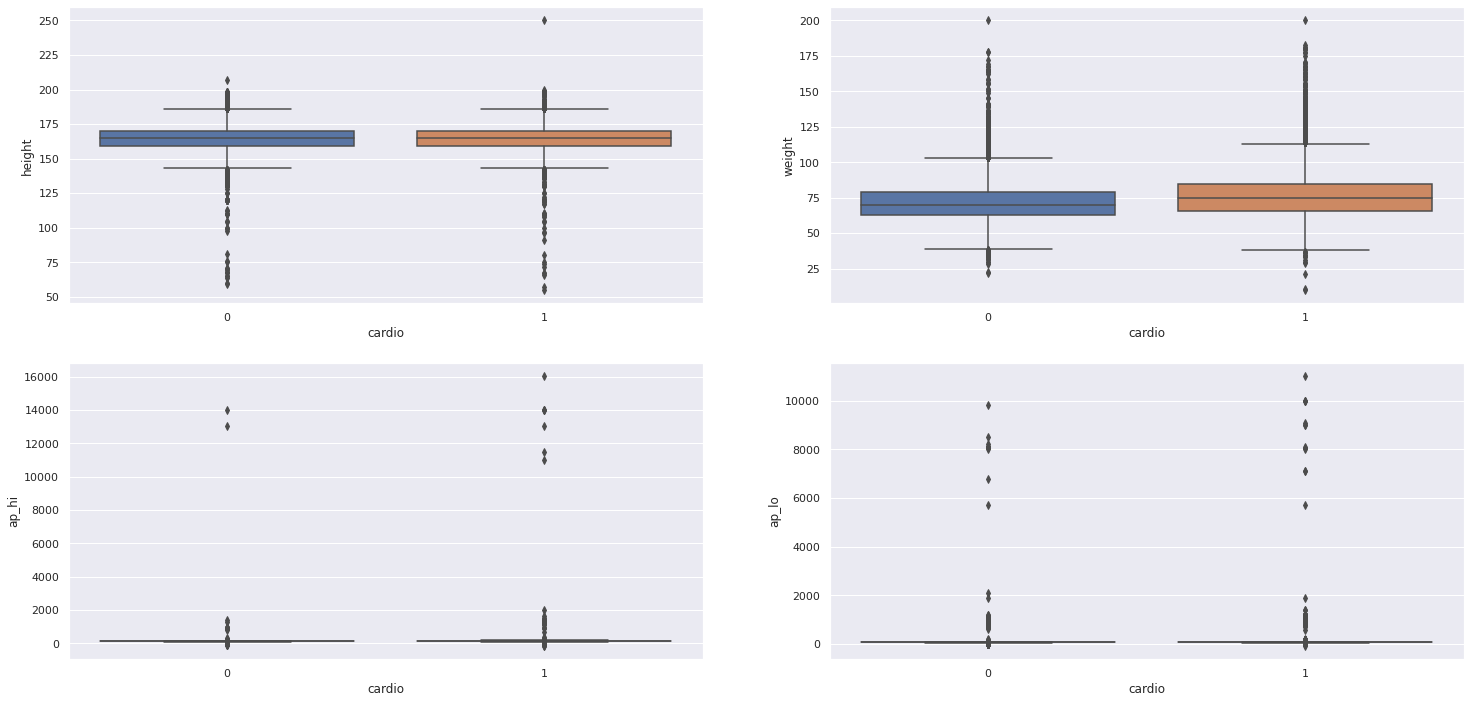

In [17]:
plt.subplot(2,2,1)
sns.boxplot(x='cardio', y='height', data=df1)

plt.subplot(2,2,2)
sns.boxplot(x='cardio', y='weight', data=df1)

plt.subplot(2,2,3)
sns.boxplot(x='cardio', y='ap_hi', data=df1)

plt.subplot(2,2,4)
sns.boxplot(x='cardio', y='ap_lo', data=df1)

#### Dealing with outliers

First, I'm going to check how many outliers I have, according to each feature above. Then, I'm going to decide the best treatment for each one

In [18]:
#height
data = df1['height']
outliers = len(detect_outlier(data))
proportion = round((outliers/df1.shape[0]) * 100, 2)
lower_bound_height = bounds(data)[0]
upper_bound_height = bounds(data)[1]
print('There are {} outliers in height, which represents {}% of the dataset'.format(outliers, proportion))
print('The lower bound is {} cm and the upper bound is {} cm'. format(lower_bound_height, upper_bound_height))
print('')

#weight
data = df1['weight']
outliers = len(detect_outlier(data))
proportion = round((outliers/df1.shape[0]) * 100, 2)
lower_bound_weight = bounds(data)[0]
upper_bound_weight = bounds(data)[1]
print('There are {} outliers in weight, which represents {}% of the dataset'.format(outliers, proportion))
print('The lower bound is {} kg and the upper bound is {} kg'. format(lower_bound_weight, upper_bound_weight))
print('')

#ap_hi
data = df1['ap_hi']
outliers = len(detect_outlier(data))
proportion = round((outliers/df1.shape[0]) * 100, 2)
lower_bound_hi = bounds(data)[0]
upper_bound_hi = bounds(data)[1]
print('There are {} outliers in systolic blood pressure, which represents {}% of the dataset'.format(outliers, proportion))
print('The lower bound is {}  and the upper bound is {} '. format(lower_bound_hi, upper_bound_hi))
print('')

#ap_lo
data = df1['ap_lo']
outliers = len(detect_outlier(data))
proportion = round((outliers/df1.shape[0]) * 100, 2)
lower_bound_lo = bounds(data)[0]
upper_bound_lo = bounds(data)[1]
print('There are {} outliers in diastolic blood pressure, which represents {}% of the dataset'.format(outliers, proportion))
print('The lower bound is {}  and the upper bound is {} '. format(lower_bound_lo, upper_bound_lo))
print('')

There are 519 outliers in height, which represents 0.74% of the dataset
The lower bound is 142.5 cm and the upper bound is 186.5 cm

There are 1819 outliers in weight, which represents 2.6% of the dataset
The lower bound is 39.5 kg and the upper bound is 107.5 kg

There are 3134 outliers in systolic blood pressure, which represents 4.48% of the dataset
The lower bound is 90.0  and the upper bound is 170.0 

There are 4730 outliers in diastolic blood pressure, which represents 6.76% of the dataset
The lower bound is 65.0  and the upper bound is 105.0 



For now, I'm going to drop all outliers to avoid any bias trying to treat and replace the data. Later on, I might try to treat each one of these features and tests what makes more sense based on researchs and studies


In [19]:
#height
df1 = df1[(df1['height'] >= lower_bound_height) & (df1['height'] <= upper_bound_height) ]

# weight 
df1 = df1[(df1['weight'] >= lower_bound_weight) & (df1['weight'] <= upper_bound_weight) ]

# ap_hi
df1 = df1[(df1['ap_hi'] >= lower_bound_hi) & (df1['ap_hi'] <= upper_bound_hi) ]

# ap_lo
df1 = df1[(df1['ap_lo'] >= lower_bound_lo) & (df1['ap_lo'] <= upper_bound_lo) ]

<AxesSubplot:xlabel='cardio', ylabel='ap_lo'>

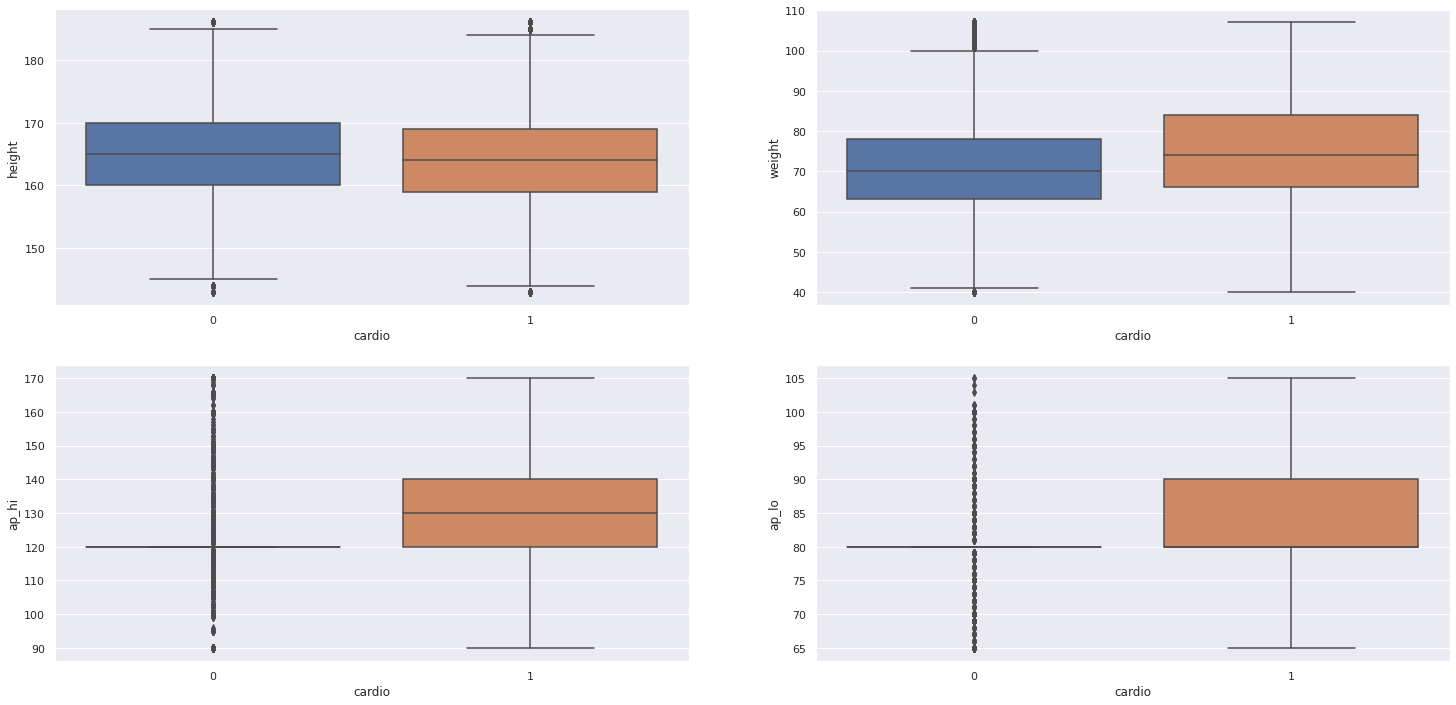

In [20]:
plt.subplot(2,2,1)
sns.boxplot(x='cardio', y='height', data=df1)

plt.subplot(2,2,2)
sns.boxplot(x='cardio', y='weight', data=df1)

plt.subplot(2,2,3)
sns.boxplot(x='cardio', y='ap_hi', data=df1)

plt.subplot(2,2,4)
sns.boxplot(x='cardio', y='ap_lo', data=df1)

### Categorical attributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender         2
cholesterol    3
gluc           3
smoke          2
alco           2
active         2
cardio         2
dtype: int64

<AxesSubplot:xlabel='cardio', ylabel='count'>

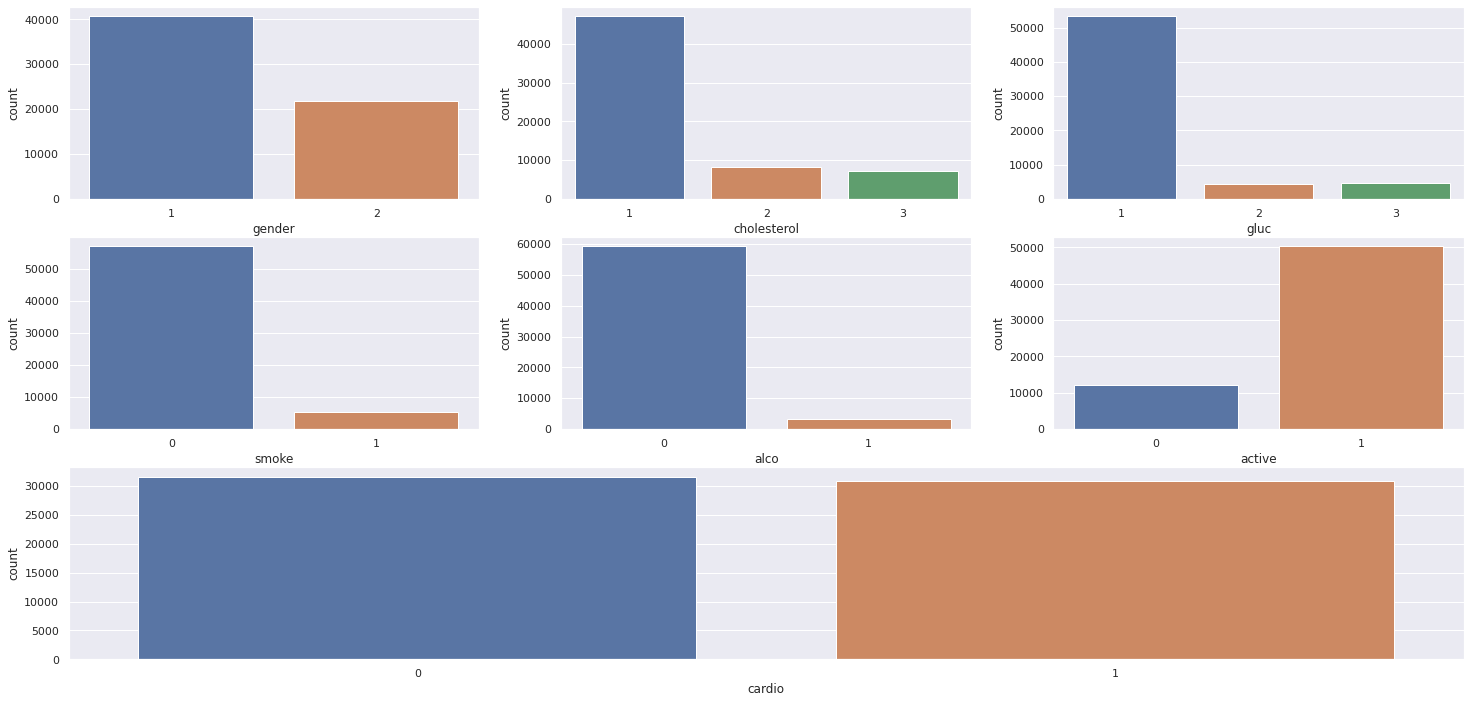

In [22]:
plt.subplot(3, 3, 1)
sns.countplot(x='gender', data=df1)

plt.subplot(3, 3, 2)
sns.countplot(x='cholesterol', data=df1)


plt.subplot(3, 3, 3)
sns.countplot(x='gluc', data=df1)

plt.subplot(3, 3, 4)
sns.countplot(x='smoke', data=df1)

plt.subplot(3, 3, 5)
sns.countplot(x='alco', data=df1)


plt.subplot(3, 3, 6)
sns.countplot(x='active', data=df1)

plt.subplot(3, 3, (7,9))
sns.countplot(x='cardio', data=df1)

Within the above results we could clearly see that our dataset is balanced between those who have cardio disease and thos who don't. However, checking the features that should indicate 'health', we could suppose that we have more healthy individuals in our dataset, which doesn't make sense

# Data cleaning

In [23]:
df1['age'] = df1['age'].astype('int64')

# Feature engineering

In [24]:
df2 = df1.copy()

## Mindmap of hypothesis

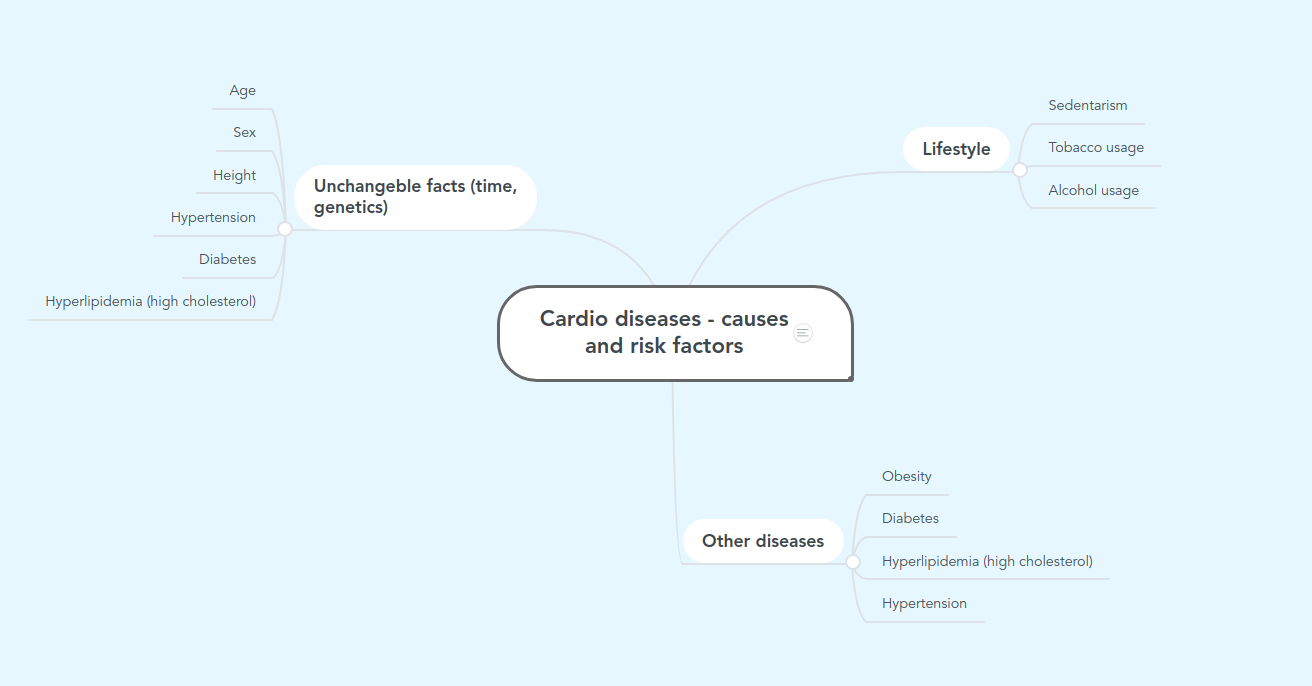

In [25]:
Image('/home/lrayssa/Documents/data_science/pa01/cardio_catch_disease/data/pa01_mindmap.png')

## Hypothesis

**H1.** People who are 50+ are more likely to have a CVD (https://www.nhs.uk/conditions/cardiovascular-disease/)<br>
**H2.** Most of people under 50+ who has a CVD are men (https://www.nhs.uk/conditions/cardiovascular-disease/)<br>
**H3.** Short people are more likely to have a CVD (https://www.escardio.org/The-ESC/Press-Office/Press-releases/Short-people-are-more-likely-to-develop-heart-disease-than-tall-people#:~:text=The%20systematic%20review%20and%20meta,it%20than%20were%20tall%20people.)<br>
**H4.** Hypertensive are more likely to have a CVD( https://www.ahajournals.org/doi/full/10.1161/HYPERTENSIONAHA.119.14240 ) <br>
**H5.** Diabetics are more likely to have a CVD (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4600176/) <br>
**H6.** People who have high levels of cholesterol are more likely to have CVD <br>
**H7.** Obese people are more likely to have a CVD <br>
**H8.** Sendentary people are more likely to have CVD <br>
**H9.** Somkers are more likely to have a CVD <br>
**H10.** People who drinks alcohol are more likely to develop CVD <br>

## Feature engineering

Hypertensive: blood pressure above 140/90 in more than one day
Diabetics: 
Obese: given IMC

In [26]:
# hypertension
df2['hypertension'] = df2.apply(lambda x: hypertension(x['ap_hi'], x['ap_lo']), axis=1)


# obesity
df2['obesity'] = df2.apply(lambda x: obesity(x['height'], x['weight']), axis=1)

#grouping by age
df2['age_group'] = df2['age'].apply(lambda x: '50+' if x >= 50 else '49-')


# crating a  height classification 
avg_h = df2['height'].mean()
max_h = df2['height'].max()
min_h = df2['height'].min()
std_h = df2['height'].std()
df2['height_class'] = df2['height'].apply(lambda x: 'tall' if (x >= avg_h + std_h ) else 'short' if (x <= avg_h - std_h) else 'regular')


# Exploratory Data Analysis - EDA

In [27]:
df3 = df2.copy()
num_attributes = df3[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'ap_hi'}>,
        <AxesSubplot:title={'center':'ap_lo'}>,
        <AxesSubplot:title={'center':'cholesterol'}>],
       [<AxesSubplot:title={'center':'gluc'}>,
        <AxesSubplot:title={'center':'smoke'}>,
        <AxesSubplot:title={'center':'alco'}>,
        <AxesSubplot:title={'center':'active'}>],
       [<AxesSubplot:title={'center':'cardio'}>,
        <AxesSubplot:title={'center':'hypertension'}>,
        <AxesSubplot:title={'center':'obesity'}>, <AxesSubplot:>]],
      dtype=object)

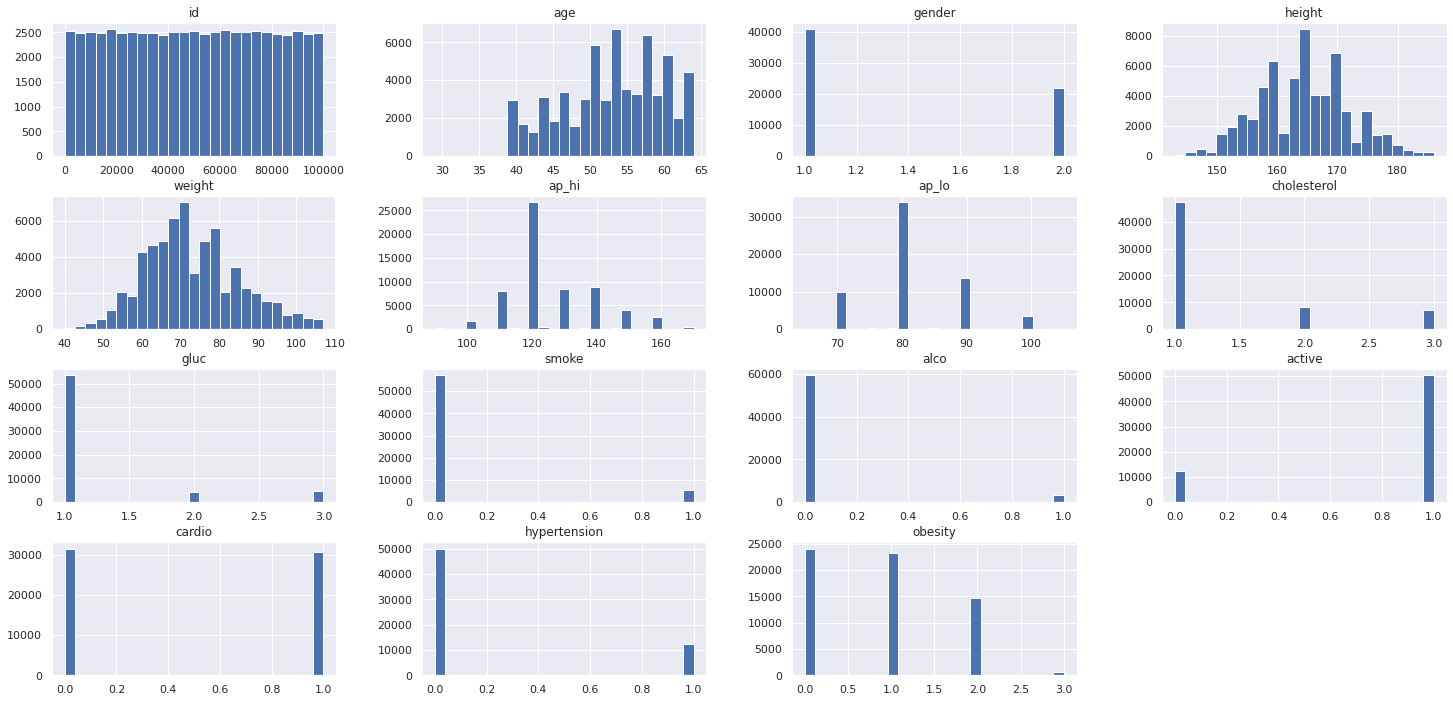

In [28]:
df3.hist( bins=25 )

## Bivariate analysis

### H1. People who are 50+ are more likely to have a CVD (TRUE)

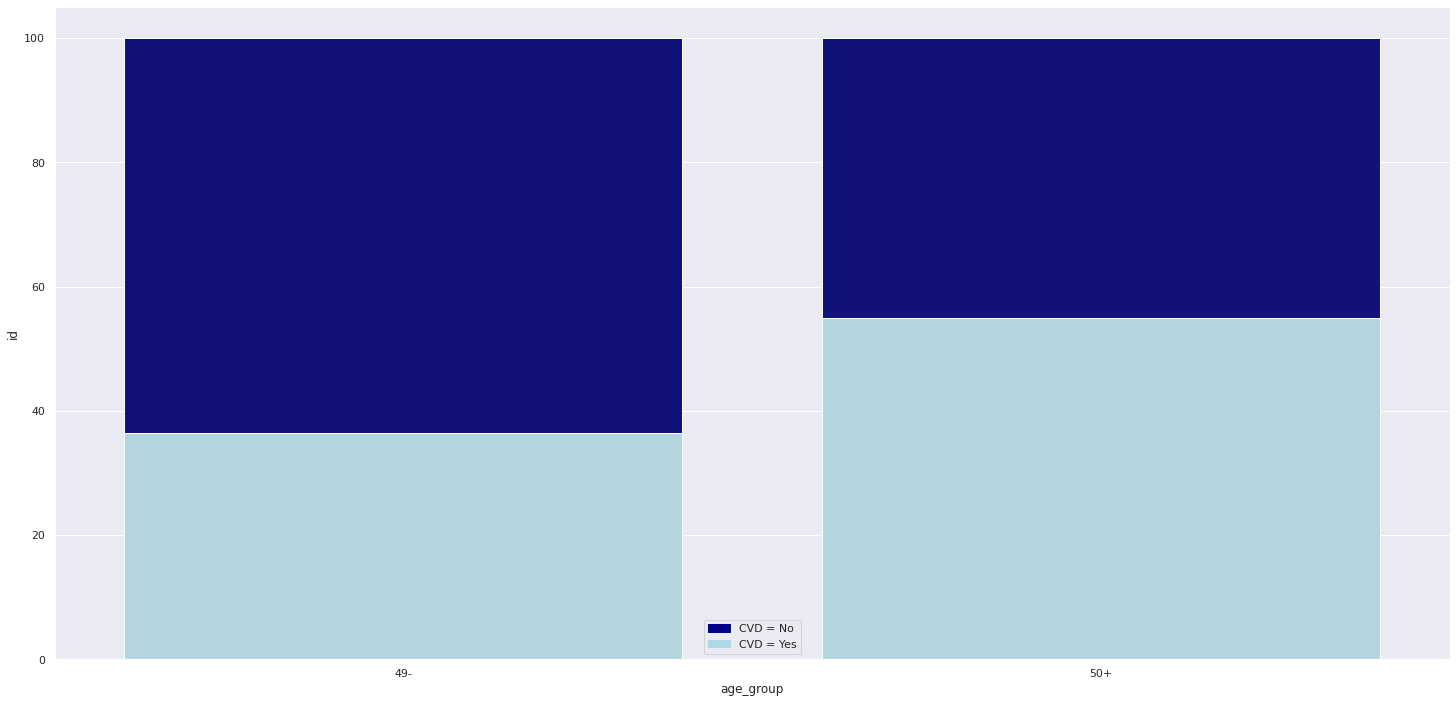

In [29]:
stacked_barplot(df3, 'age_group')

### H2.  Most of people under 50+ who has a CVD are men (FALSE)

<AxesSubplot:xlabel='gender', ylabel='age'>

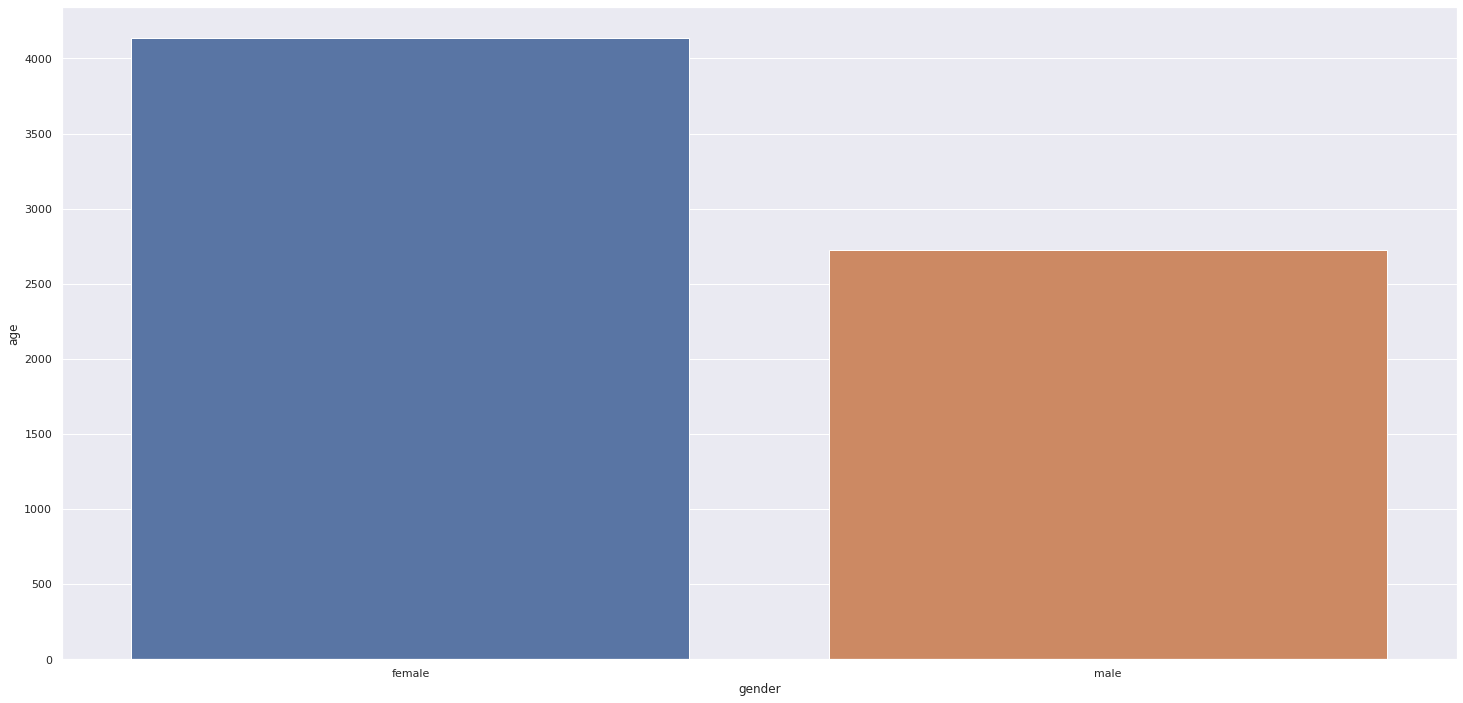

In [30]:
aux = df3[['age', 'gender', 'cardio']]
aux = aux[(aux['cardio'] == 1) & (aux['age'] < 50)]
aux = aux.groupby('gender').count().reset_index()
aux['gender'] = aux['gender'].apply(lambda x: 'female' if x==1 else 'male')
sns.barplot(x='gender', y='age', data=aux)

### H3.  Short people are more likely to have a CVD (TRUE BUT NOT SIGNIFICANT)

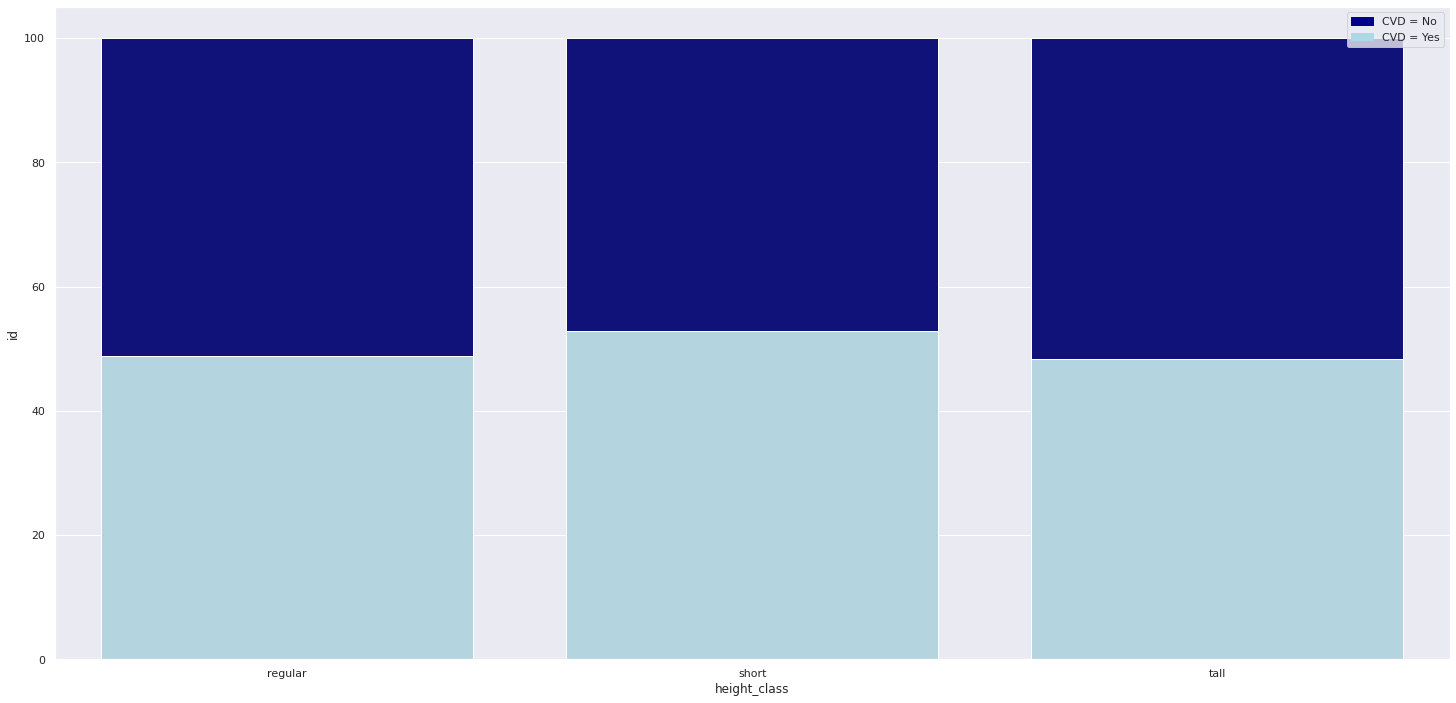

In [31]:
stacked_barplot(df3, 'height_class')

### H4. Hypertensive are more likely to have a CVD (TRUE)

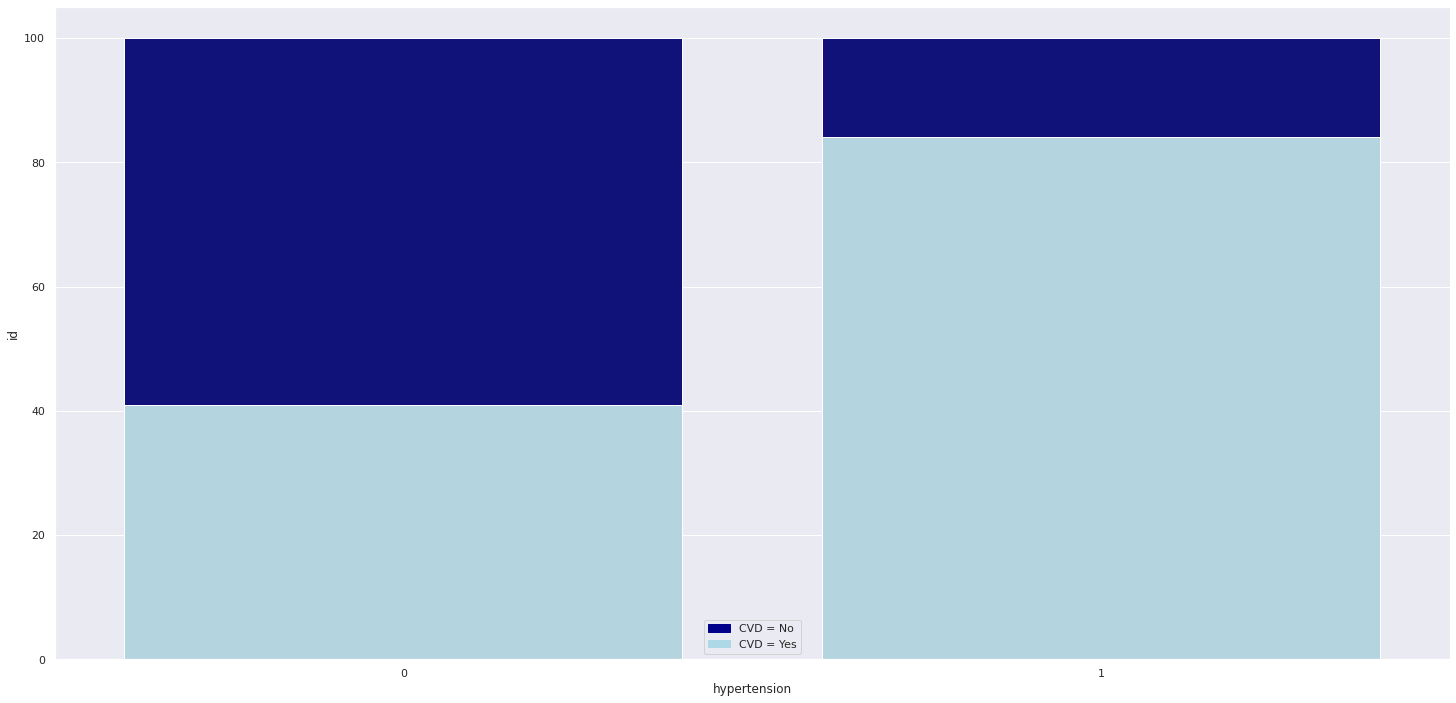

In [32]:
stacked_barplot(df3, 'hypertension')

### H5. Diabetics are more likely to have a CVD (TRUE BUT NOT SIGINIFICANT)

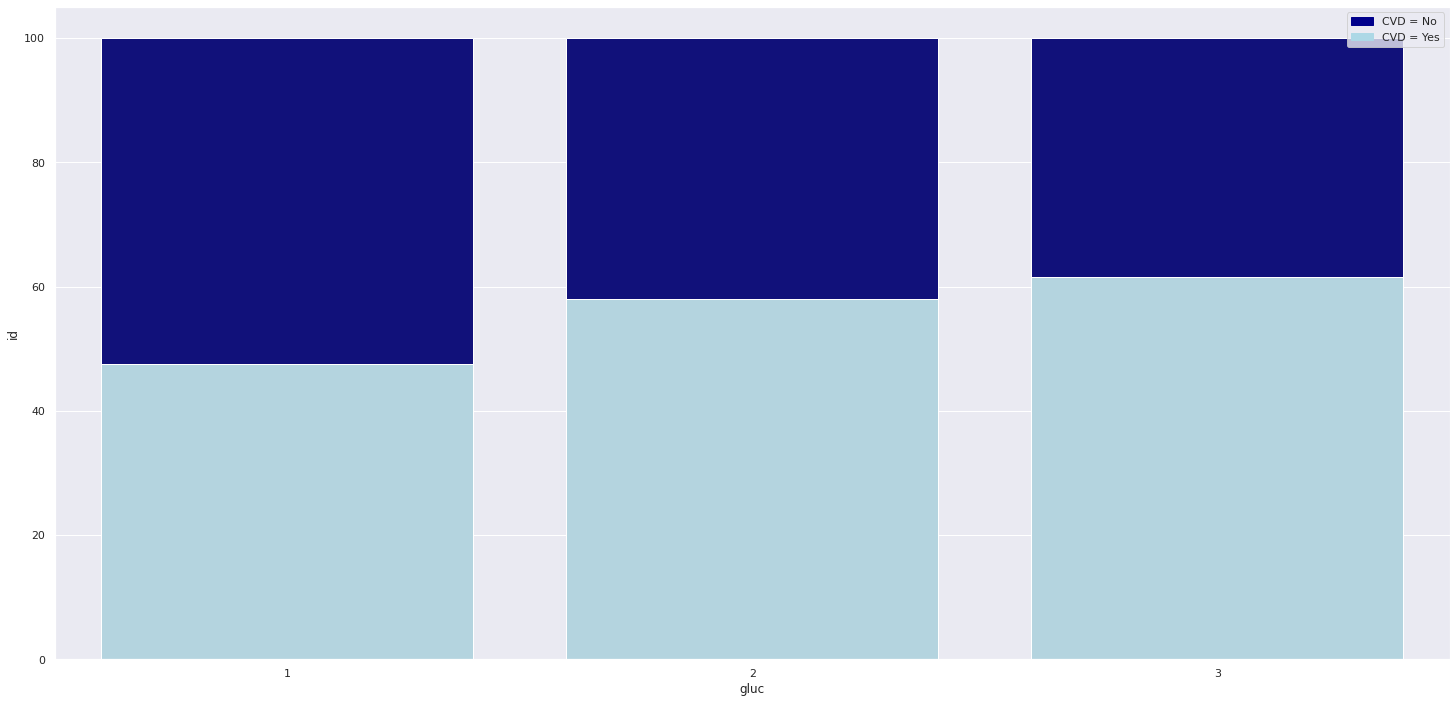

In [33]:
stacked_barplot(df3 , 'gluc')

### H6. People who have high levels of cholesterol are more likely to have CVD (TRUE)

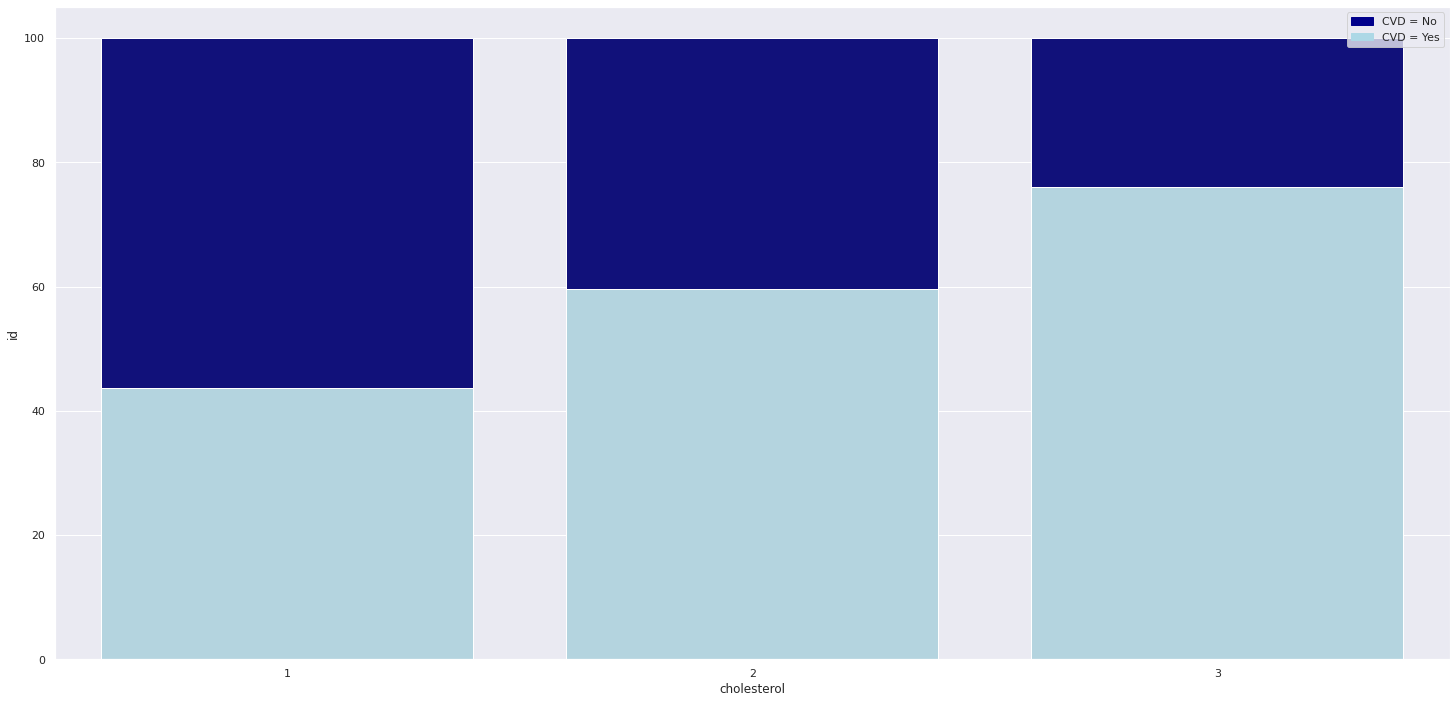

In [34]:
stacked_barplot(df3, 'cholesterol')

### H7. Obese people are more likely to have a CVD (TRUE)

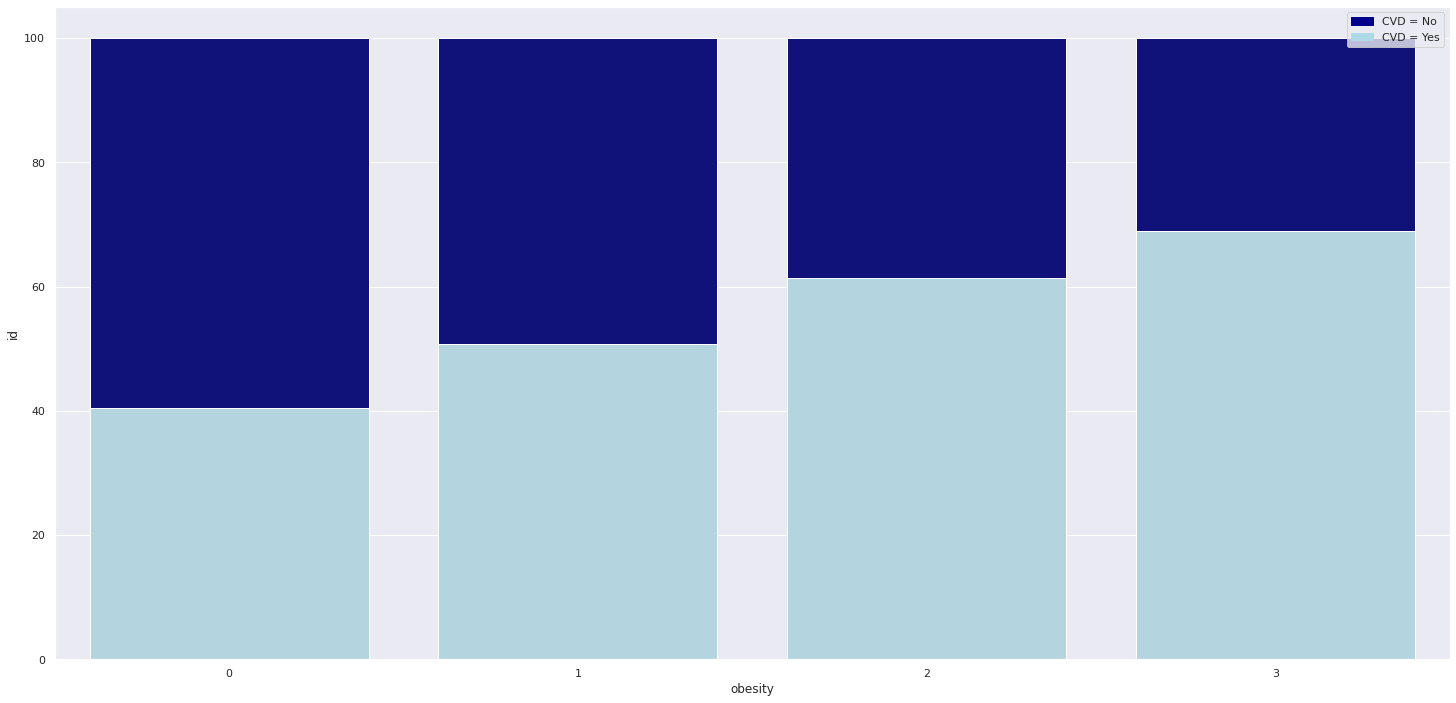

In [35]:
stacked_barplot(df3, 'obesity')

### H8. Sendentary people are more likely to have CVD (FALSE)

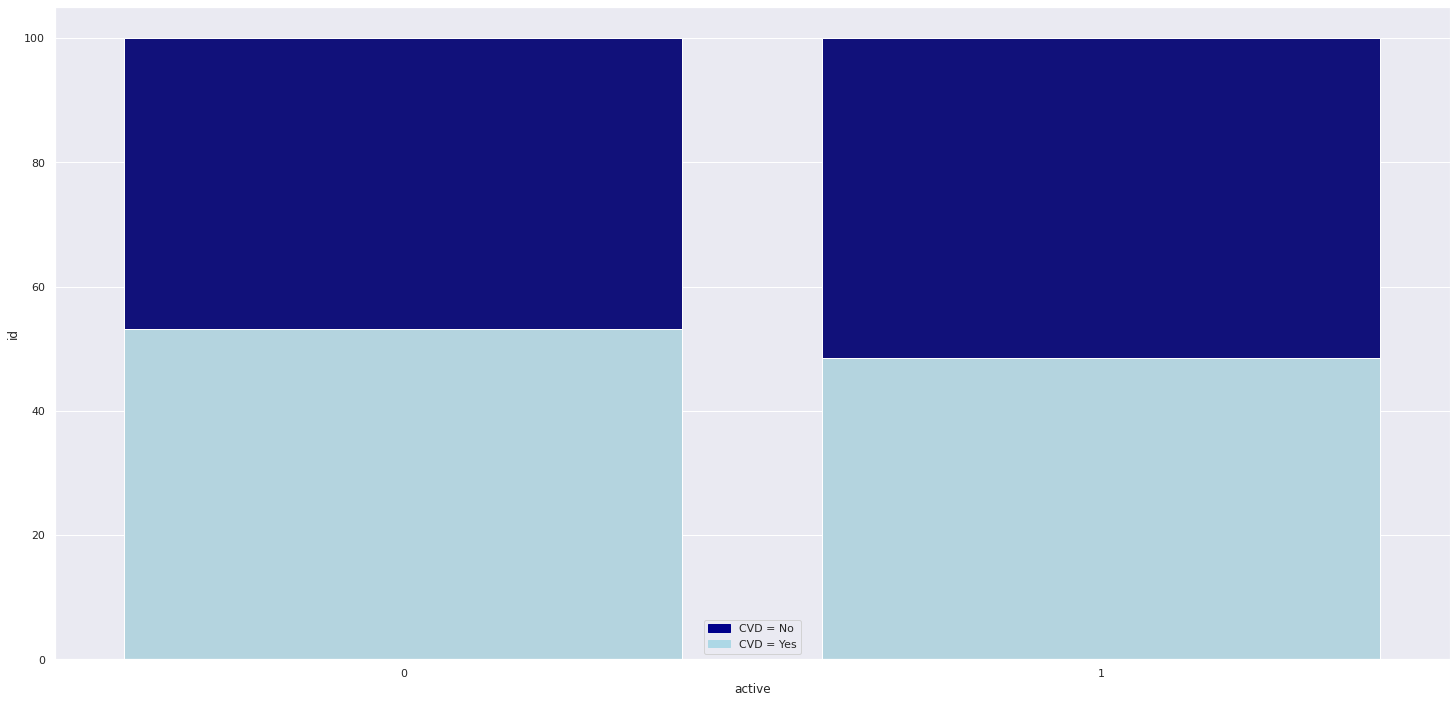

In [36]:
stacked_barplot(df3, 'active')

### H9. Smokers are more likely to have a CVD (FALSE)

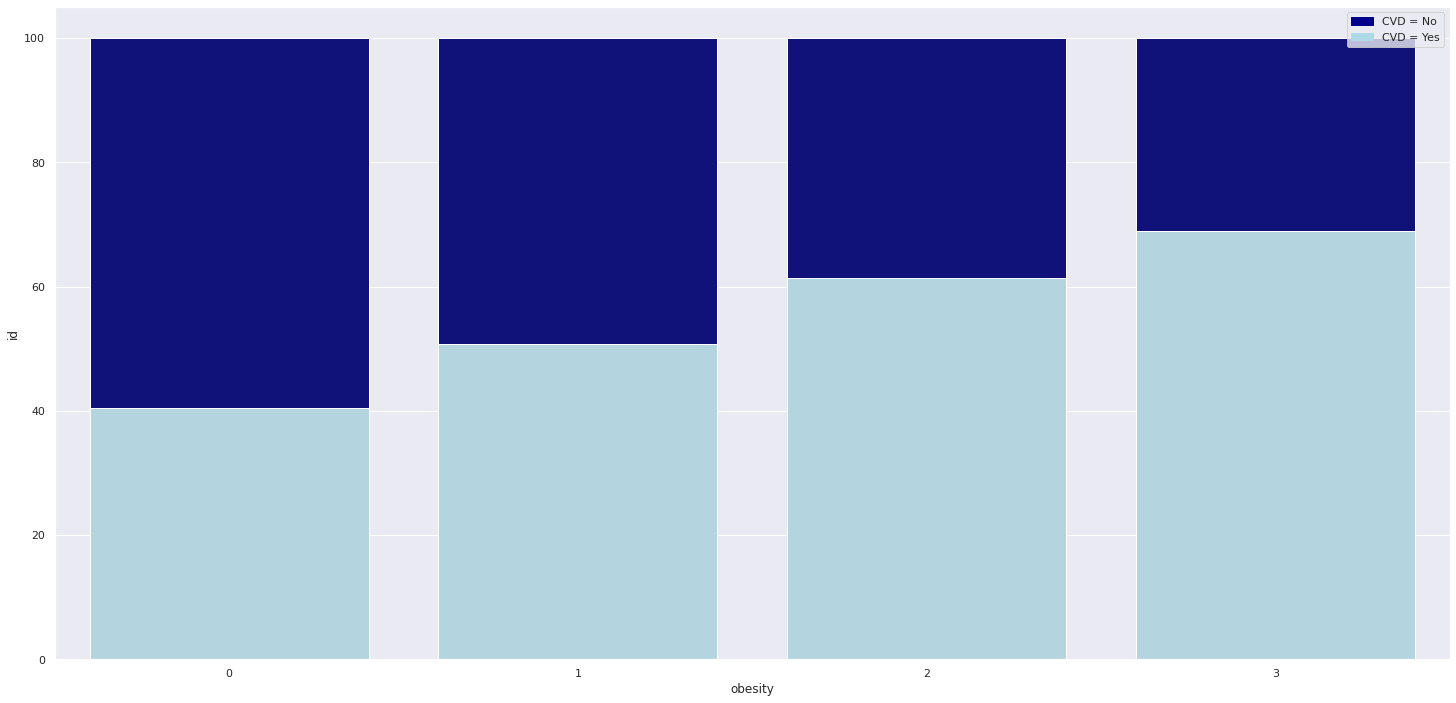

In [37]:
stacked_barplot(df3, 'obesity')

### H10.  People who drinks alcohol are more likely to develop CVD (FALSE)

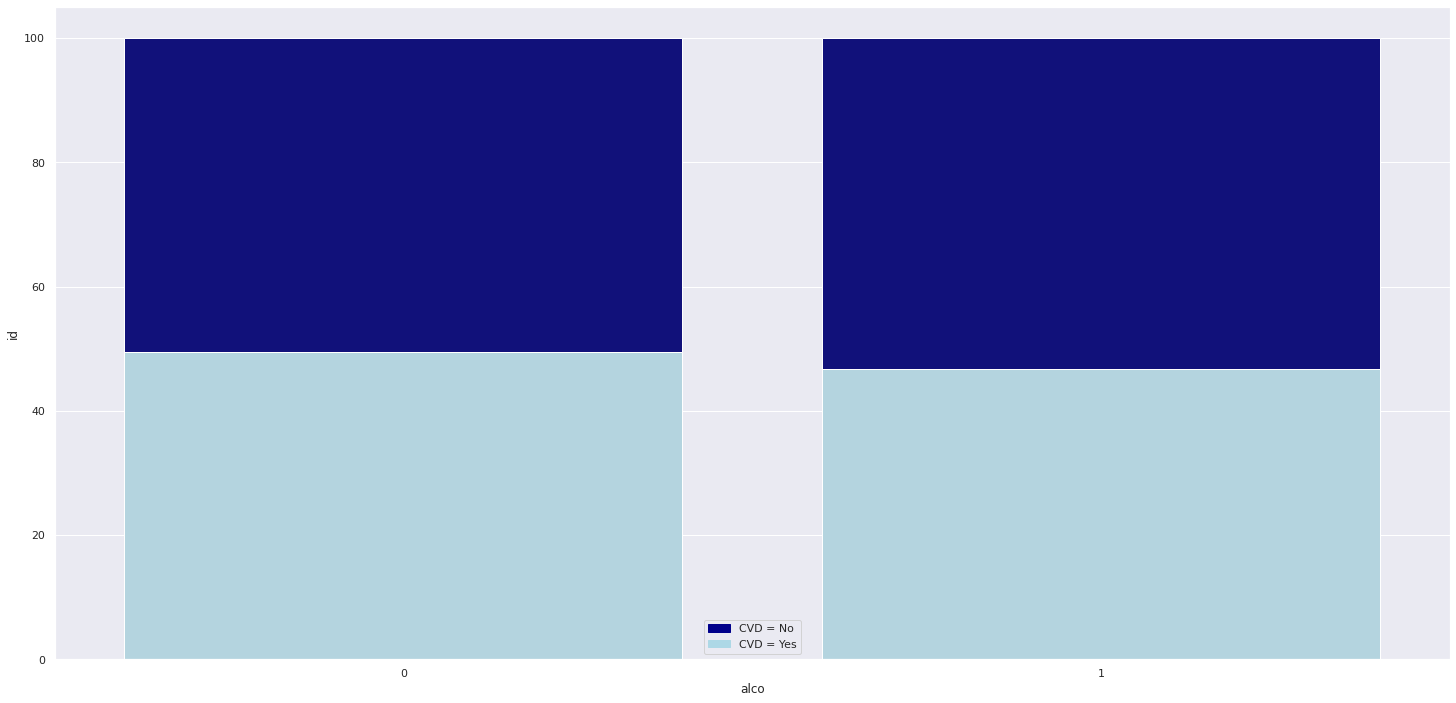

In [38]:
stacked_barplot(df3, 'alco')

Data gotten by examination are more reliable than others such as smoking, activeness and drinking information because the patient can lie

## Multivarite Analysis

<AxesSubplot:>

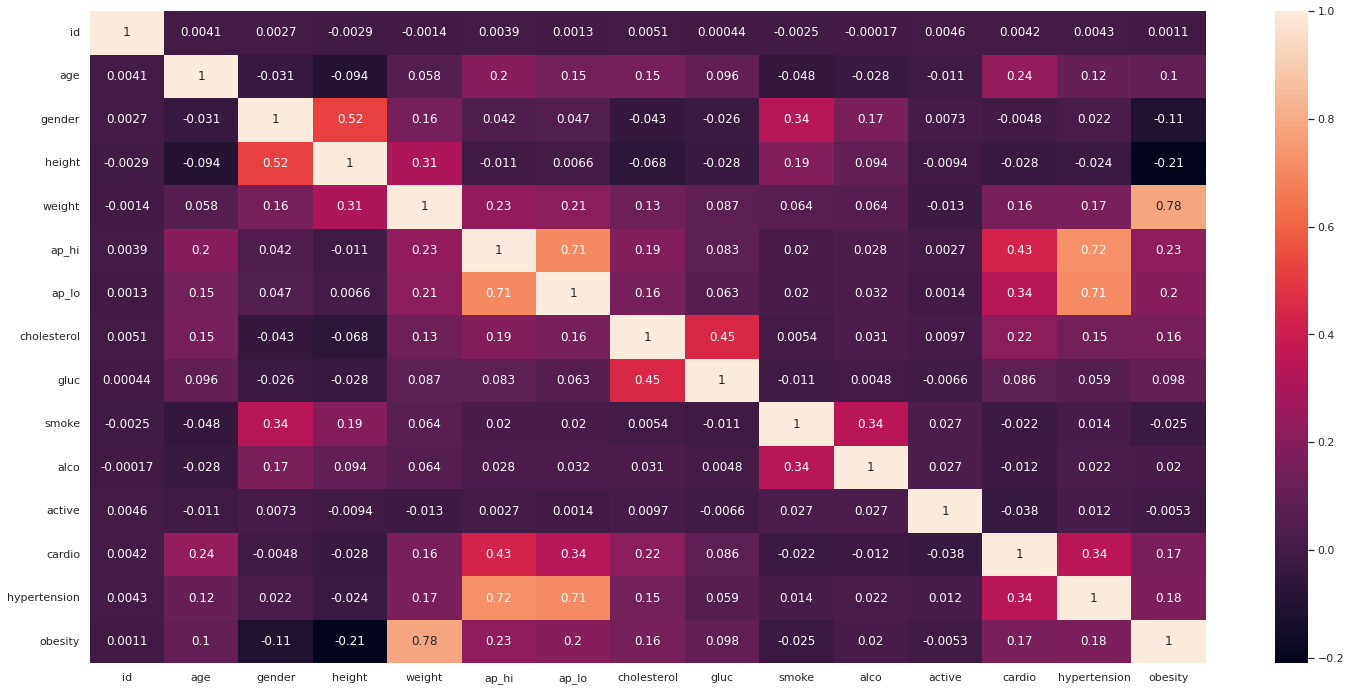

In [39]:
correlation = df3.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

# Data preparation

In [40]:
df4 = df3.copy()

In [41]:
df4.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,hypertension,obesity,age_group,height_class
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,0,0,50+,regular
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,1,2,50+,short
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,0,0,50+,regular
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,1,1,49-,regular
5,8,60,1,151,67.0,120,80,2,2,0,0,0,0,0,1,50+,short


## Rescaling

In [45]:
# define min max scaler
mms = MinMaxScaler()


#age 
df4['age'] = mms.fit_transform(df4[['age']].values)

#height
df4['height'] = mms.fit_transform(df4[['height']].values)


#weight
df4['weight'] = mms.fit_transform(df4[['weight']].values)

#ap_hi
df4['ap_hi'] = mms.fit_transform(df4[['ap_hi']].values)


#ap_lo
df4['ap_lo'] = mms.fit_transform(df4[['ap_lo']].values)

In [48]:
df4.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,hypertension,obesity,age_group,height_class
0,0,0.600000,2,0.581395,0.328358,0.250,0.375,1,1,0,0,1,0,0,0,50+,regular
1,1,0.742857,1,0.302326,0.671642,0.625,0.625,3,1,0,0,1,1,1,2,50+,short
2,2,0.628571,1,0.511628,0.358209,0.500,0.125,3,1,0,0,0,1,0,0,50+,regular
3,3,0.542857,2,0.604651,0.626866,0.750,0.875,1,1,0,0,1,1,1,1,49-,regular
5,8,0.885714,1,0.186047,0.402985,0.375,0.375,2,2,0,0,0,0,0,1,50+,short


In [49]:
df4 = df4.drop(columns = ['age_group', 'height_class'])

In [50]:
df4.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,hypertension,obesity
0,0,0.600000,2,0.581395,0.328358,0.250,0.375,1,1,0,0,1,0,0,0
1,1,0.742857,1,0.302326,0.671642,0.625,0.625,3,1,0,0,1,1,1,2
2,2,0.628571,1,0.511628,0.358209,0.500,0.125,3,1,0,0,0,1,0,0
3,3,0.542857,2,0.604651,0.626866,0.750,0.875,1,1,0,0,1,1,1,1
5,8,0.885714,1,0.186047,0.402985,0.375,0.375,2,2,0,0,0,0,0,1


# Feature selection

In [71]:
df5 = df4.copy()

## Train test split

In [78]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## Boruta as feature selector

In [82]:
#training and test dataset for Boruta
x_train_n = x_train.values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
I

In [86]:
 cols_selected = boruta.support_.tolist()
    
#best feature
x_train_fs = x_train
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()
print('Columns selected: ',cols_selected_boruta)

#not selected from Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
print('Columns not selected: ', cols_not_selected_boruta)

Columns selected:  ['ap_hi']
Columns not selected:  ['active', 'age', 'alco', 'ap_lo', 'cholesterol', 'gender', 'gluc', 'height', 'hypertension', 'id', 'obesity', 'smoke', 'weight']
